In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
#import matplotlib.pyplot as plt
import numpy as np
import json
import os
from IPython.core.display import display
print("Modules imported!")

Modules imported!


In [2]:
def read_json(file_path):
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf8") as file:
            data = json.load(file)
        # print(f"Data read from path: {file_path}")
        return data
    else:
        print(f"No data found at path: {file_path}")
        return {}

def serialize_json(filename, data):
    with open(filename, "w", encoding="utf8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        #print(f"Data serialized to path: {filename}")

In [3]:
# Data correction: there was a bug in the given framework causing timestamps in data_try_{n}.json to be wrong

# for workerDir in os.scandir('../Data/'):
#     if workerDir.name in ['ATCOU', 'BOJHZ', 'DJTWC', 'EOTDA', 'FLXYV', 'HQWLU', 'JQJWV', 'KAHOD', 'KDOFG', 'LZZBM', 'MLENI', 'UPVVU', 'VKFXZ', 'VNPSK', 'VXCGS', 'ZLAXX']:
#         data_try = read_json(workerDir.path + "/data_try_1.json")
#         for workerJson in os.scandir(workerDir.path):
#             if workerJson.name.startswith('quest') or workerJson.name.startswith('doc'):
#                 sourceJson = read_json(workerJson.path)
#                 if workerJson.name.startswith('quest'):
#                     data_try['timestamps_end'][0][0] = sourceJson['timestamps_end'][0]
#                     data_try['timestamps_elapsed'][0][0] = sourceJson['timestamps_elapsed']
#                 else:
#                     workerJson_split = workerJson.name.split('_')
#                     docIndex = int(workerJson_split[1])
#                     docTry = int(workerJson_split[5])
#                     data_try['timestamps_end'][docIndex][docTry - 1] = sourceJson['timestamps_end'][docTry - 1]
#                     data_try['timestamps_elapsed'][docIndex][docTry - 1] = sourceJson['timestamps_elapsed']
#         serialize_json(workerDir.path + "/data_try_1.json", data_try)
# for workerDir in os.scandir('../Data/'):
#     if workerDir.name in ['ATCOU', 'BOJHZ', 'DJTWC', 'EOTDA', 'FLXYV', 'HQWLU', 'JQJWV', 'KAHOD', 'KDOFG', 'LZZBM', 'MLENI', 'UPVVU', 'VKFXZ', 'VNPSK', 'VXCGS', 'ZLAXX']:
#         data_try = read_json(workerDir.path + "/data_try_1.json")
#         elapsed = []
#         for time in data_try['timestamps_elapsed']:
#             elapsed.append(time[-1])
#         data_try['timestamps_elapsed'] = elapsed
#         serialize_json(workerDir.path + "/data_try_1.json", data_try)

In [4]:
# Worker analysis
workerInfoList = []
for workerDir in os.scandir('../Data/'):
    task_data = read_json(workerDir.path + "/task_data.json")
    data_try = read_json(workerDir.path + "/data_try_1.json")
    questionnaire = task_data['questionnaires'][0]['questions']
    reformatQuest = {}
    for question in questionnaire:
        reformatQuest[question['name']] = question['answers']
    device = task_data["worker"]['ngxDeviceDetectorProperties']["device"]
    if device == 'Unknown':
        device = task_data["worker"]['ngxDeviceDetectorProperties']["os"]
    workerInfo = {}
    for key, value in data_try['questionnaires_answers'][0].items():
        workerInfo[key] = reformatQuest[key][int(value)]
    workerInfo['device'] = device
    workerInfoList.append(workerInfo)

df = pd.DataFrame.from_dict(workerInfoList)
display(df)

# Save the dataframe to json
df.to_json("dataframes/questionnaire.json")

,Età,Lavoro,Genere letterario preferito,kindle,Importanza,Quanti libri,device
0,36-45,Dipendente,Biografia,No,Scarsa,3-5,Mac
1,46-55,Freelancer,Formazione,No,Discreta,3-5,Windows
2,18-25,Studente,Rosa,Si,Fondamentale,0,iPhone
3,18-25,Studente,Psicologico,Si,Fondamentale,11+,Android
4,18-25,Studente,Giallo,Si,Discreta,1-2,Android
5,18-25,Studente,Giallo,Si,Discreta,6-10,Windows
6,18-25,Studente,Biografia,No,Fondamentale,6-10,Windows
7,18-25,Studente,Commedia,No,Fondamentale,6-10,iPhone
8,18-25,Studente,Sci-Fi,Si,Scarsa,1-2,Linux
9,18-25,Studente,Avventura,No,Fondamentale,6-10,Android


In [5]:
sunburst_df = df.copy()
sunburst_df["kindle"] = sunburst_df["kindle"].apply({'Si': 'Ha un<br>eReader', 'No': 'Non ha un<br>eReader'}.get)
sunburst_device = px.sunburst(sunburst_df, path=['Età', 'Lavoro', 'device', 'kindle'])
sunburst_device.show()
force = False
if not os.path.isfile('./plot/sunburst_device.html') or force:
    sunburst_device.write_html('./plot/sunburst_device.html')
    sunburst_device.write_image('./plot/sunburst_device.png')
sunburst_genre = px.sunburst(sunburst_df, path=['Età', 'Lavoro', 'Genere letterario preferito'])
sunburst_genre.show()
force = False
if not os.path.isfile('./plot/sunburst_genre.html') or force:
    sunburst_genre.write_html('./plot/sunburst_genre.html')
    sunburst_genre.write_image('./plot/sunburst_genre.png')


In [6]:
# -- ABSOLUTE AND RELATIVE FOR ALL QUEST PARAMETERS IN JSON -- 

# Count occourences
counter = {key:dict(Counter(df[key])) for key in df}

reformatQuestCount = {}
reformatQuestCountRel = {}

# Absolute frequencies for each option of each parameter
for key, value in reformatQuest.items():
    reformatQuestCount[key] = {label:counter[key].get(label, 0) for label in value}
    
# Relative frequencies for each option of each parameter 
for key, value in reformatQuestCount.items():
    total = sum(value.values())
    if total != 0:
        reformatQuestCountRel[key] = {label:counter[key].get(label, 0)/total for label in value.keys()}
    else:
        reformatQuestCountRel[key] = {label:0 for label in value.keys()}

# You can call this functions to save counts in json format on the current path
def serialize_count():
    serialize_json("dataframes/quest_count.json", reformatQuestCount)
    serialize_json("dataframes/quest_count_rel.json", reformatQuestCount)

serialize_count()

In [7]:
def get_freq(df, column):
    out_df = df\
        .groupby(by=column)\
        .count()[['device']]\
        .reset_index()\
        .rename(columns={'device':'f'})\
        .sort_values(by=['f'], ascending=False)

    return out_df

def to_relative_freq(df, column='f'):
    total_amount = df['f'].sum()
    df['f'] = df['f'] / total_amount
    
    return df

def save_plot(figure, name, force=False):
    if not os.path.isfile(f'./plot/{name}.html') or force:
        figure.write_html(f'./plot/{name}.html')
        figure.write_image(f'./plot/{name}.png')

In [8]:
# Convert the genre list into a df
df_genre = pd.DataFrame(reformatQuest['Genere letterario preferito'], columns=['Genere letterario preferito'])

# Count occurrences, transform in a df and rename
counts = df['Genere letterario preferito']\
    .value_counts()\
    .to_frame()\
    .rename(columns={'Genere letterario preferito': 'f'})

# Join the previous two, replace NaN with 0s and sort everything for better view
df_genre = df_genre\
    .join(counts, on='Genere letterario preferito')\
    .replace(np.NaN, 0)\
    .sort_values(by='f', ascending=False)

# From float to int
df_genre['f'] = df_genre['f'].astype(int)

# Relative freq
total_amount = df_genre['f'].sum()
df_genre['f'] = df_genre['f'] / total_amount

# Plot everything
bar_genre = px.bar(df_genre, x = 'Genere letterario preferito', y = 'f', labels={'f': 'Frequenza'}, color='Genere letterario preferito')

# Add % sign to the ticks
bar_genre.update_layout(yaxis_tickformat = '%')
bar_genre.show()
save_plot(bar_genre, 'bar_genre')

In [9]:
# Plot based on genre and age
df_genre_age = get_freq(df, ['Genere letterario preferito', 'Età'])

# Relative freq
df_genre_age = to_relative_freq(df_genre_age)

bar_genre_age = px.bar(df_genre_age, x = 'Genere letterario preferito', labels = {'f': 'Frequenza'}, y = 'f', color='Età')

# Add % sign to the ticks
bar_genre_age.update_layout(yaxis_tickformat = '%')

bar_genre_age.show()
save_plot(bar_genre_age, 'bar_genre_age')

In [10]:
# Create dataframe
df_age = df[['Età']]

# Normalize ages to create a 
age_normalized = []
for _, row in df_age.iterrows():
    key = row['Età']
    if key == '18-25':
        age_normalized.append(18)
    elif key == '26-35':
        age_normalized.append(26)
    elif key == '36-45':
        age_normalized.append(36)
    elif key == '46-55':
        age_normalized.append(46)
    else:
        age_normalized.append(56)

df_age_normalized = pd.DataFrame(age_normalized)

# plt.hist(df_age_normalized, bins=[18,26,36,46,56,100], density=True)
hist_age = px.histogram(df_age_normalized, histnorm='probability', range_x=[18,66], labels={'value':'Età'})

hist_age.update_traces(
    xbins=dict( # bins used for histogram
        start=16,
        end=80,
        size=10
    )
)

hist_age.update_layout(
    showlegend=False,
    yaxis_title='Frequenza',
    yaxis_tickformat = '%'
)

hist_age.show()

save_plot(hist_age, 'hist_age')

In [11]:
# Barplot for ages instead of histogram, if needed at all
df_age2 = get_freq(df, "Età")
df_age2 = to_relative_freq(df_age2)

df_age2 = df_age2.reindex([0,1,2,3,4])

bar_age = px.bar(df_age2, x='Età', y='f', color='Età', labels={'Età': 'Fascia d\'età','f': 'Frequenza'})

bar_age.update_layout(
    showlegend=False,
    yaxis_tickformat = '%'
)

bar_age.show()
save_plot(bar_age, 'bar_age')

In [12]:
# Kindle

df_kindle = get_freq(df, 'kindle')

# Relative freq
df_kindle = to_relative_freq(df_kindle)

bar_kindle = px.bar(df_kindle, x='kindle', y='f', color='kindle', labels={'kindle': 'Possessori di kindle o ', 'f': 'Frequenza'})

bar_kindle.update_layout(
    showlegend=False,
    yaxis_tickformat = '%'
)

bar_kindle.show()

save_plot(bar_kindle, 'bar_kindle', True)

In [13]:
# Importanza della lettura
df_reading = get_freq(df, 'Importanza')

# Sort based on Likert scale
df_reading = df_reading.reindex([2,3,0,1])

# Relative freq
df_reading = to_relative_freq(df_reading)

bar_reading = px.bar(df_reading, x='Importanza', y='f', color='Importanza', labels={'Importanza': 'Importanza della lettura', 'f': 'Frequenza'})

bar_reading.update_layout(
    showlegend=False,
    yaxis_tickformat = '%'
)

bar_reading.show()

save_plot(bar_reading, 'bar_reading')

In [14]:
# Number of books read per year
df_books_read = get_freq(df, 'Quanti libri')

# Sort based on Likert scale
df_books_read = df_books_read.reindex([0,1,3,4,2])

# Relative freq
df_books_read = to_relative_freq(df_books_read)

# Address the plotly bug which ignores the dtype
# df_books_read['Quanti libri'][0] = 'Nessuno'
# A canta funziona, PARKOUR
# ░░▄░░░▄░▄▄▄▄░░░░░░░░░░░░░░░
# ░░█▀▄▀█░█▄▄░░░░░░░░░░░░░░░░
# ░░█░░░█░█▄▄▄░░░░░░░░░░░░░░░
# ░░░░░░░░░░░░░░░░░░░░░░░░░░░
# ░▄▄▄░▄░░░▄░░▄▄▄░▄▄▄▄▄░░▄▄▄░
# █░░░░█░░░█░█░░░░░░█░░░█░░░█
# █░▀█░█░░░█░░▀▀▄░░░█░░░█▀▀▀█
# ░▀▀▀░░▀▀▀░░▄▄▄▀░░░▀░░░▀░░░▀

bar_books_read = px.bar(df_books_read, x='Quanti libri', y='f', color='Quanti libri', labels={'Quanti libri': 'Numero di libri letti in un anno', 'f': 'Frequenza'})

bar_books_read.update_layout(
    showlegend=False,
    yaxis_tickformat = '%'
)

bar_books_read.show()

save_plot(bar_books_read, 'bar_books_read')

In [15]:
# Opinions retrieved from task

commentDict = {}
for workerDir in os.scandir('../Data/'):
    if os.path.isfile(f'{workerDir.path}/comment_try_1.json'):
        comment = read_json(f'{workerDir.path}/comment_try_1.json')
        if comment['comment'] != '':
            commentDict[workerDir.name] = comment['comment']
serialize_json('comment_summary.json', commentDict)
commentDict


{'AGGBZ': "Mi ha fatto piacere partecipare. \nSpero di esservi stata d'aiuto nel vostro progetto universitario. \n",
 'ZLAXX': 'Il test è strutturato molto bene, non modificherei nulla',
 'EVDDT': 'Alla grandine, bel lavoro',
 'RYYES': "sono contento di essere stato utile per un'attività che servirà per la formazione di giovani studenti  ",
 'CFRLM': 'Grazie',
 'SARZI': 'Devo ancora capire il senso di qst test... ',
 'THRZI': 'Tutto perfetto! Davvero complimenti ',
 'EOTDA': 'Spero di essere stato utile',
 'IMHHT': 'Organizzazione ottima anche nella versione per telefono',
 'ITCXH': 'Ciao!! ',
 'HBIRW': 'Va bene così',
 'ACHTQ': 'La parte della giustificazione è troppo lunga. Obbligare ad inserire minimo 10 parole mi ha quasi fatto passar la voglia di fare questo questionario. ',
 'KAHOD': 'Grazie.',
 'HDLGN': 'Dal telefono quando passo da un libro all’altro preferirei ricaricasse la pagina dall’inizio senza costringermi a scorrere in alto.'}

In [16]:
# Worker HITS data
worker_data = []
for worker_dir in os.scandir('../Data/'):
    data_try = read_json(worker_dir.path + "/data_try_1.json")
    task_data = read_json(worker_dir.path + "/task_data.json")
    worker_data.append((data_try, task_data))

# Get books info
df_all_books = pd.read_csv('../pyHITS/libri.csv', sep=';').reset_index()

dict_data = {
    'edizione_id': [],
    'hai_letto': [],
    'sfoglieresti': [],
    'compreresti': [],
    'prezzo_adeguato': [],
    'quanto_prezzo_adeguato': [],
    'impressione_valore': [],
    'impressione_testo': [],
    'time_elapsed': []
}

def get_edition_index(current_book):
    for _, book in df_all_books.iterrows():
        if current_book['title'] == book['title'] and current_book['type']  == book['type'] and current_book['language'] == book['language']:
            return book['index']
    print('YoUsTOn we got a problem')

for entry in worker_data:
    data, task = entry

    for book in task['documents']:
        dict_data['edizione_id'].append(get_edition_index(book))
    
    for answers in data['documents_answers']:

        dict_data['hai_letto'].append(int(answers['Hai letto questo libro?_value']))
        dict_data['sfoglieresti'].append(int(answers['Sfoglieresti il libro vedendone la copertina?_value']))
        dict_data['compreresti'].append(int(answers['Compreresti questa edizione del libro? (eventualmente supponendo di non possederlo già)_value']))
        dict_data['prezzo_adeguato'].append(int(answers['Il prezzo è adeguato?_value']))
        dict_data['quanto_prezzo_adeguato'].append(int(answers['Indica quanto ti sembra adeguato:_value']))
        dict_data['impressione_valore'].append(int(answers['Quali sono le tue impressioni su questa edizione del libro?_value']))
        dict_data['impressione_testo'].append(answers['Quali sono le tue impressioni su questa edizione del libro?_justification'])

    for index, timestamp in enumerate(data['timestamps_elapsed']):
        if index != 0: # first timestamp is the questionnaire
            if type(timestamp) == list:
                dict_data['time_elapsed'].append(timestamp[-1])
            else:
                dict_data['time_elapsed'].append(timestamp)

df_data = pd.DataFrame(dict_data)

# display(df_data)
df_data.to_json("dataframes/worker_data.json")

In [20]:
df_data


,edizione_id,hai_letto,sfoglieresti,compreresti,prezzo_adeguato,quanto_prezzo_adeguato,impressione_valore,impressione_testo,time_elapsed
0,0,0,1,0,1,4,1,"Pur non essendo il mio genere preferito, resta...",237.434
1,4,0,0,0,0,2,0,Trovo il prezzo un po' elevato trattandosi di ...,215.457
2,8,0,0,0,0,3,0,Sicuramente non fa parte dei libri che leggere...,138.754
3,0,0,0,0,1,5,0,"E' un genere di lettura fantasy, azione, avven...",384.331
4,7,0,0,0,1,5,0,E' un genere di lettura che non rientra nei mi...,142.697
...,...,...,...,...,...,...,...,...,...
154,4,1,0,0,0,1,0,il libro e' vecchio e per una versione digital...,130.285
155,8,1,0,1,1,4,1,conosco l' autore e per un libro così importan...,179.731
156,0,1,1,1,1,4,1,I colori della copertina sono incisivi e i car...,100.216
157,7,1,0,0,1,5,0,La copertina è bruttissima e i colori sono sgr...,90.472


In [17]:
"""
Calcolate le seguenti misure per ciascuna edizione:

    Grado medio di adeguatezza del prezzo
    Edizione con il livello massimo di adeguatezza del prezzo
    Edizione con il livello minimo di adeguatezza del prezzo
"""

# MEAN
mean_edition = df_data\
    .groupby('edizione_id')\
    .mean()

print("=============== MEAN ===============")
display(mean_edition)

# MEDIAN
median_edition = df_data\
    .groupby('edizione_id')\
    .median()

print("=============== MEDIAN ===============")
display(median_edition)

# MIN
min_edition = df_data\
    .groupby('edizione_id')\
    .min()

print("=============== MIN ===============")
display(min_edition)

# MAX
max_edition = df_data\
    .groupby('edizione_id')\
    .max()

print("=============== MAX ===============")
display(max_edition)

=============== MEAN ===============


,hai_letto,sfoglieresti,compreresti,prezzo_adeguato,quanto_prezzo_adeguato,impressione_valore,time_elapsed
edizione_id,,,,,,,
0,0.333333,0.444444,0.277778,0.944444,3.944444,0.555556,203.004556
1,0.117647,0.588235,0.588235,0.764706,3.764706,0.647059,150.360000
2,0.055556,0.500000,0.277778,0.833333,3.222222,0.444444,188.815778
3,0.058824,0.529412,0.294118,0.882353,3.764706,0.647059,195.363118
4,0.388889,0.722222,0.666667,0.722222,3.444444,0.666667,180.487444
5,0.388889,0.833333,0.777778,0.833333,3.888889,0.666667,151.748222
6,0.277778,0.388889,0.388889,0.833333,3.666667,0.388889,262.673111
7,0.166667,0.277778,0.388889,0.722222,3.666667,0.444444,146.652056
8,0.176471,0.411765,0.352941,0.823529,3.823529,0.352941,153.331529


=============== MEDIAN ===============


,hai_letto,sfoglieresti,compreresti,prezzo_adeguato,quanto_prezzo_adeguato,impressione_valore,time_elapsed
edizione_id,,,,,,,
0,0.0,0.0,0.0,1.0,4.0,1.0,166.0020
1,0.0,1.0,1.0,1.0,4.0,1.0,122.0040
2,0.0,0.5,0.0,1.0,3.0,0.0,153.4990
3,0.0,1.0,0.0,1.0,4.0,1.0,188.0050
4,0.0,1.0,1.0,1.0,4.0,1.0,165.0900
5,0.0,1.0,1.0,1.0,4.0,1.0,96.8370
6,0.0,0.0,0.0,1.0,3.5,0.0,200.3445
7,0.0,0.0,0.0,1.0,4.0,0.0,130.6425
8,0.0,0.0,0.0,1.0,4.0,0.0,121.8240


=============== MIN ===============


,hai_letto,sfoglieresti,compreresti,prezzo_adeguato,quanto_prezzo_adeguato,impressione_valore,impressione_testo,time_elapsed
edizione_id,,,,,,,,
0,0,0,0,0,3,0,"180 pagine sono troppo poche, il libro finisce...",98.098
1,0,0,0,0,1,0,Comunque io credo che in modalità cartacea sia...,70.523
2,0,0,0,0,1,0,Avendo visto il film potrei pensare ad acquist...,54.608
3,0,0,0,0,1,0,"Anche se non l’ho letto, conosco la storia e l...",72.597
4,0,0,0,0,1,0,Anche questa copertina è molto interessante. S...,43.847
5,0,0,0,0,2,0,Amando questa scrittrice posso dire che lo com...,38.223
6,0,0,0,0,0,0,Appare un'ottima edizine a chi è interessato a...,81.875
7,0,0,0,0,0,0,Avendo letto parte di questo libro e confronta...,39.165
8,0,0,0,0,1,0,"Amo un'altro genere di lettura , non questa.no...",40.698


=============== MAX ===============


,hai_letto,sfoglieresti,compreresti,prezzo_adeguato,quanto_prezzo_adeguato,impressione_valore,impressione_testo,time_elapsed
edizione_id,,,,,,,,
0,2,1,1,1,5,1,È un bel libro fantasy e soprattutto ho visto ...,477.573
1,1,1,1,1,5,1,la copertina incuriosisce e fa intuire in part...,390.038
2,1,1,1,1,5,1,Sempra un libro di avventura che mi puo appass...,463.652
3,1,1,1,1,5,1,Ottimo libro lo stile della copertina rispecch...,409.309
4,1,1,1,1,5,1,sembra un libro per preadolescenti dalla coper...,433.494
5,2,1,1,1,5,1,"buon libero per avvicinarsi al genere giallo, ...",365.270
6,1,1,1,1,5,1,È un'edizione del libro abbastanza recente e c...,679.613
7,1,1,1,1,5,1,Ritengo che il genere del libro in questione n...,501.189
8,1,1,1,1,5,1,non dedicherei il mio tempo per leggere questo...,497.069


In [27]:
"""
Calcolate le seguenti misure per ciascuna edizione:

    Grado medio di adeguatezza del prezzo
    Edizione con il livello massimo di adeguatezza del prezzo
    Edizione con il livello minimo di adeguatezza del prezzo
"""

# Grado medio di adeguatezza del prezzo
display(mean_edition[['prezzo_adeguato', 'quanto_prezzo_adeguato']], median_edition[['prezzo_adeguato', 'quanto_prezzo_adeguato']])

# Edizione con il livello massimo di adeguatezza del prezzo
display(max_edition[['prezzo_adeguato', 'quanto_prezzo_adeguato']])

# Edizione con il livello minimo di adeguatezza del prezzo
display(min_edition[['prezzo_adeguato', 'quanto_prezzo_adeguato']])

,prezzo_adeguato,quanto_prezzo_adeguato
edizione_id,,
0,0.944444,3.944444
1,0.764706,3.764706
2,0.833333,3.222222
3,0.882353,3.764706
4,0.722222,3.444444
5,0.833333,3.888889
6,0.833333,3.666667
7,0.722222,3.666667
8,0.823529,3.823529


,prezzo_adeguato,quanto_prezzo_adeguato
edizione_id,,
0,1.0,4.0
1,1.0,4.0
2,1.0,3.0
3,1.0,4.0
4,1.0,4.0
5,1.0,4.0
6,1.0,3.5
7,1.0,4.0
8,1.0,4.0


,prezzo_adeguato,quanto_prezzo_adeguato
edizione_id,,
0,1,5
1,1,5
2,1,5
3,1,5
4,1,5
5,1,5
6,1,5
7,1,5
8,1,5


,prezzo_adeguato,quanto_prezzo_adeguato
edizione_id,,
0,0,3
1,0,1
2,0,1
3,0,1
4,0,1
5,0,2
6,0,0
7,0,0
8,0,1


In [ ]:
"""
Aggregate i dati calcolati al punto precedente e:

    Calcolate il grado medio di adeguatezza del prezzo
    Calcolate lo scarto quadratico medio (deviazione standard) del grado di adeguatezza del prezzo
    Determinate quale libro ha il grado più alto di adeguatezza del prezzo
"""

# TODO
# Aspettiamo la risposto di Soprano

In [18]:
"""
Elencate le giustificazioni fornite dai worker e:

    Calcolate la lunghezza media
    Determinate la giustificazione più lunga
    Determinate la giustificazione più corta
"""
# Show justifications and create a json of justifications
justification_dict = df_data['impressione_testo'].to_dict()
serialize_json("justifications.json", justification_dict)

# Should we apply lemming removing articles and stuff?     
giustifications_len = df_data['impressione_testo']\
    .apply(lambda x: x.split(" "))\
    .apply(len)\
    .to_frame()

# Mean explanation length, then the longest and the shortest ones
print("\033[92m\033[1mMEAN\033[0m")
print(f"The mean is {giustifications_len['impressione_testo'].mean()}")
print()

print("\033[92m\033[1mMAX\033[0m")
print(f"Maximum length is {giustifications_len['impressione_testo'].max()}")
index_max = giustifications_len['impressione_testo'].idxmax()
print(f"\n\"{df_data['impressione_testo'][index_max]}\"")
print()\

print("\033[92m\033[1mMIN\033[0m")
print(f"Minum length is {giustifications_len['impressione_testo'].min()}")
index_min = giustifications_len['impressione_testo'].idxmin()
print(f"\n\"{df_data['impressione_testo'][index_min]}\"")

MEAN
The mean is 17.232704402515722

MAX
Maximum length is 70

"Viene spesso detto di non giudicare il libro dalla copertina ma la realtà secondo me è diversa, molto spesso in una libreria i libri che ci attirano si piú sono quelli con una copertina accattivante, elaborata e particolare.
La storia narrata è sicuramente di mio gradimento e su questo non ho nulla da dire.
Avendolo già letto lo consiglierei o acquisterei volentieri ma, per attrarre maggior clientela si dovrebbe migliorare la facciata."

MIN
Minum length is 11

"Trovo il prezzo un po' elevato trattandosi di una versione digitale"


In [43]:
"""
Calcoliamo la correlazione fra la possessione di un kindle e la tendenza a comprare un libro in uno specifico formato
"""

dict_kindle_quest = {
    'book_is_kindle': [],
    'has_kindle': [],
    'would_buy': []
}

def check_book_is_kindle_edition(current_book):
    return 1 if current_book['type'] == 'Kindle' else 0

for worker_dir in os.scandir('../Data/'):
    data_try = read_json(worker_dir.path + "/data_try_1.json")
    task_data = read_json(worker_dir.path + "/task_data.json")

    for book in task_data['documents']:
        dict_kindle_quest['book_is_kindle'].append(check_book_is_kindle_edition(book))

    for doc in data_try['documents_answers']:
        dict_kindle_quest['would_buy'].append(int(doc['Compreresti questa edizione del libro? (eventualmente supponendo di non possederlo già)_value']))
    
    has_kindle = int(data_try['questionnaires_answers'][0]['kindle'])
    for i in range(len(data_try['documents_answers'])): # always 3
        dict_kindle_quest['has_kindle'].append(has_kindle)

df_kindle_quest = pd.DataFrame(dict_kindle_quest)

display(df_kindle_quest)

,book_is_kindle,has_kindle,would_buy
0,0,1,0
1,1,1,0
2,0,1,0
3,0,1,0
4,1,1,0
...,...,...,...
154,1,0,0
155,0,0,1
156,0,1,1
157,1,1,0


In [89]:
df_kindle_books = df_kindle_quest[df_kindle_quest['book_is_kindle']==1][['has_kindle','would_buy']]

corr = df_kindle_books.corr()['would_buy']['has_kindle']
print(f"Correlation with kindle books: {corr}")

df_nonkindle_books = df_kindle_quest[df_kindle_quest['book_is_kindle']==0][['has_kindle','would_buy']]

corr = df_nonkindle_books.corr()['would_buy']['has_kindle']
print(f"Correlation with non-kindle books: {corr}")

Correlation with kindle books: -0.047723149742940715
Correlation with non-kindle books: 0.16315769782009587


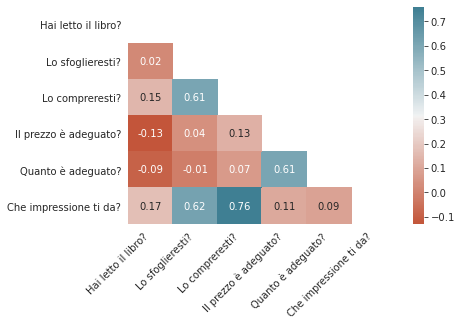

In [151]:
# Voler sfogliare è sinonimo di interesse riguardo l'acquisto del libro??

import seaborn as sns

df_data[['sfoglieresti', 'compreresti']].corr()

correlation = df_data.drop(['edizione_id', 'time_elapsed'], axis=1).corr().apply(lambda x: round(x, 2))
# display(correlation)
labels = [
    'Hai letto il libro?', 
    'Lo sfoglieresti?',
    'Lo compreresti?',
    'Il prezzo è adeguato?',
    'Quanto è adeguato?',
    'Che impressione ti da?'
]

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    cmap = sns.diverging_palette(20, 220, n=200)
    fig = sns.heatmap(correlation, mask=mask, cmap=cmap, annot=True, fmt='.2f')
    fig.set_xticklabels(labels=labels, rotation=45, ha='right')
    fig.set_yticklabels(labels=labels)
    fig.figure.savefig('plot/correlation_plot.png', bbox_inches="tight", pad_inches=0.0, dpi=300)